# NLP Project Sentiment Analysis with BERT
## Apple data December 2021

Label description:
* 0: positive sentiment
* 1: negative sentiment
* None: no label

## Setup

In [1]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install tensorflow --quiet 
!pip install sklearn --quiet
!pip install tensorflow-addons --quiet

In [129]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix
from huggingface_hub import notebook_login
from transformers.keras_callbacks import PushToHubCallback
from transformers import create_optimizer
from tensorflow.keras.callbacks import ModelCheckpoint
import time


In [198]:

os.chdir(r"\Users\JSchuettler\OneDrive - Universität St.Gallen\Courses\WS 21\NLP with Transformers")
root_dir = os.getcwd()


In [199]:
# To use the data I import it as a pandas data frame
dataset = pd.read_csv('Apple.csv')

## Explore the data

###Plots and Data

In [200]:
dataset.head(3)

,created_at,id,username,name,user_id,body,basic_sentiment
0,2021-12-31 23:57:27+00:00,422497650,hoyasaxa1978,hoyasaxa1978,819540,"$AAPL 🍏 In the “final second” of the Close, 8...",0.0
1,2021-12-31 23:51:08+00:00,422496711,InsiderFinance,InsiderFinance_io,4012623,Sweep Options Activity: $AAPL is the #1 ticker...,NaN
2,2021-12-31 23:48:33+00:00,422496310,OptionsQueenTrader,Malika,5498543,$SPY next year we will go low real low. Expect...,1.0


In [201]:
dataset.columns


Index(['created_at', 'id', 'username', 'name', 'user_id', 'body',
       'basic_sentiment'],
      dtype='object')

In [202]:
#Look at tweets
print(dataset['body'][3])

$AAPL someone told me Apple will announce Apple car in September 2022, is it true? Will Apple stock price drop after that just like when they announce the new iPhone every year?


In [203]:
# Make a histogramm of the labels
#sns.countplot(dataset['basic_sentiment'],label='Count')
#label imbalance
#stratified train test split (Verteilung beider labels sollte in splitted datasets das gleiche Verhältnis haben) sklearn function hat das
#when training the model there is a parameter "importance/weights" (tensor flow bei model.fit classweight oder sample_weigth)
#Bei evaluierung nicht accuracy wählen!  confusion matrix  anschauen (F1 score, F beta score, precision recall)

In [204]:
#Length of the tweets
#generate an additional column that contains the length of the tweets
dataset['length']=dataset['body'].apply(len)
dataset['length'].describe()

count    47521.000000
mean        95.721681
std        109.907828
min          5.000000
25%         33.000000
50%         62.000000
75%        118.000000
max       2390.000000
Name: length, dtype: float64

In [205]:
#shortest tweet
print(dataset[dataset['length']==5]['body'].iloc[0])
#longest tweet
print(dataset[dataset['length']==2390]['body'].iloc[0])

$AAPL
@Jimmyboy29 $AAPL missed last earnings on 10l/28, and is up 21% since then, trollboy. 🍏📈 
 
https://finance.yahoo.com/quote/AAPL/chart?p=AAPL#eyJpbnRlcnZhbCI6ImRheSIsInBlcmlvZGljaXR5IjoxLCJjYW5kbGVXaWR0aCI6MjcuNjgyOTI2ODI5MjY4MjkzLCJ2b2x1bWVVbmRlcmxheSI6dHJ1ZSwiYWRqIjp0cnVlLCJjcm9zc2hhaXIiOnRydWUsImNoYXJ0VHlwZSI6ImxpbmUiLCJleHRlbmRlZCI6ZmFsc2UsIm1hcmtldFNlc3Npb25zIjp7fSwiYWdncmVnYXRpb25UeXBlIjoib2hsYyIsImNoYXJ0U2NhbGUiOiJwZXJjZW50IiwicGFuZWxzIjp7ImNoYXJ0Ijp7InBlcmNlbnQiOjEsImRpc3BsYXkiOiJBQVBMIiwiY2hhcnROYW1lIjoiY2hhcnQiLCJpbmRleCI6MCwieUF4aXMiOnsibmFtZSI6ImNoYXJ0IiwicG9zaXRpb24iOm51bGx9LCJ5YXhpc0xIUyI6W10sInlheGlzUkhTIjpbImNoYXJ0Iiwidm9sIHVuZHIiXX19LCJsaW5lV2lkdGgiOjIsInN0cmlwZWRCYWNrZ3JvdW5kIjp0cnVlLCJldmVudHMiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN0cmlwZWRCYWNrZ3JvdWQiOnRydWUsImV2ZW50TWFwIjp7ImNvcnBvcmF0ZSI6eyJkaXZzIjp0cnVlLCJzcGxpdHMiOnRydWV9LCJzaWdEZXYiOnt9fSwiY3VzdG9tUmFuZ2UiOnsic3RhcnQiOjE2MzU0MDQ0MDAwMDAsImVuZCI6MTY0MDI0NjQwMDAwMH0sInN5bWJvbHMiOlt7InN5bWJvbCI6IkFBUEwiLCJzeW1i

<AxesSubplot:ylabel='Frequency'>

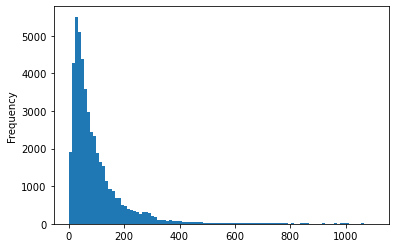

In [206]:
#histogramm of tweet length
dataset['length'].plot(bins=100,kind='hist',range = [0,1100])

###Create a WordCloud

In [207]:
#Postitive labels
positive = dataset[dataset['basic_sentiment']==0]
negative = dataset[dataset['basic_sentiment']== 1]

#Turn all tweets into one string 
sentences = dataset['body'].tolist() #turns the tweet column into a list
len(sentences) # list has same length as number of tweets
sentences_as_one_string = "".join(sentences) # turns all sequences into one string

sentences_positive = positive['body'].tolist() #turns the tweet column into a list # list has same length as number of tweets
sentences_as_one_string_positive = "".join(sentences_positive) # turns all sequences into one string

sentences_negative = negative['body'].tolist() #turns the tweet column into a list # list has same length as number of tweets
sentences_as_one_string_negative = "".join(sentences_negative) # turns all sequences into one string


In [208]:
!pip install WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  Running setup.py clean for WordCloud
Failed to build WordCloud
    Running setup.py install for WordCloud: started
    Running setup.py install for WordCloud: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\JSchuettler\Anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\JSchuettler\\AppData\\Local\\Temp\\pip-install-q0b8se57\\wordcloud_6c92cd3341ed4d729948a13ea3fb25c1\\setup.py'"'"'; __file__='"'"'C:\\Users\\JSchuettler\\AppData\\Local\\Temp\\pip-install-q0b8se57\\wordcloud_6c92cd3341ed4d729948a13ea3fb25c1\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\JSchuettler\AppData\Local\Temp\pip-wheel-eawew15k'
       cwd: C:\Users\JSchuettler\AppData\Local\Temp\pip-install-q0b8se57\wordcloud_6c92cd3341ed4d729948a13ea3fb25c1\
  Complete output (20 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  cr

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
#postive WordCloud
plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string_positive))

In [ ]:
#negative WordCloud
plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string_negative))

## Data Preprocessing 
All unlabeled rows are dropped. 
I further delete all columns except for body (which contains the tweet) and basic sentiment which corresponds to the label.

In [209]:
dataset = dataset[['body','basic_sentiment']]
dataset = dataset.dropna()
dataset['basic_sentiment'] = dataset['basic_sentiment'].astype(int)
dataset.dtypes

body               object
basic_sentiment     int32
dtype: object

In [210]:
#dataset = dataset[:70]
print(dataset.shape)

(25026, 2)


# Calculate the class weights 

In [211]:
pos, neg= np.bincount(dataset['basic_sentiment'])
total = pos+neg
print('positive sentiment (class 0):', pos,'\n negatives sentiment (class 1):',neg, '({:.2f}% of total)\n'.format(
     100 * neg / total))


positive sentiment (class 0): 17587 
 negatives sentiment (class 1): 7439 (29.73% of total)



In [212]:
weight_for_0 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / neg) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (positives sentiment): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (negatives sentiment): {:.2f}'.format(weight_for_1))


Weight for class 0 (positives sentiment): 0.71
Weight for class 1 (negatives sentiment): 1.68


# Create a dataset.Dataset from pandas df

In [213]:
# create huggingface/ arrow dataset from pandas df
dataset = Dataset.from_pandas(dataset).remove_columns("__index_level_0__")


In [214]:
print("before: ",dataset.features)
# add labels to sentiment scores for better readability
feat_sentiment = ClassLabel(num_classes = 2,names=["negative", "positive"])
dataset = dataset.cast_column("basic_sentiment", feat_sentiment)
print("after: ", dataset.features)

before:  {'body': Value(dtype='string', id=None), 'basic_sentiment': Value(dtype='int32', id=None)}


Casting the dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

after:  {'body': Value(dtype='string', id=None), 'basic_sentiment': ClassLabel(num_classes=2, names=['negative', 'positive'], names_file=None, id=None)}


In [215]:
#Split into training and test data
dataset_split = dataset.train_test_split(test_size=0.1) # to apply train_test_split I need to have a dataset not a datasetDict object 
train_data = dataset_split['train']
test_data = dataset_split['test']

#Split training data into training and validation data
train_data_split = train_data.train_test_split(test_size=1/9)
train_data = train_data_split['train']
validation_data = train_data_split['test']


In [216]:
dataset = DatasetDict({
    'train': train_data,
    'validation': validation_data,
    'test': test_data
})

print(dataset)
dataset['train'].features

DatasetDict({
    train: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 20020
    })
    validation: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 2503
    })
    test: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 2503
    })
})


{'body': Value(dtype='string', id=None),
 'basic_sentiment': ClassLabel(num_classes=2, names=['negative', 'positive'], names_file=None, id=None)}

### Check distribution of labels wihtin the random subsamples and calculate the classweights





In [217]:
pos_train, neg_train = np.bincount(dataset['train']['basic_sentiment'])
print('positive sentiment (class 0):', pos_train,'\n negatives sentiment (class 1):',neg_train, '({:.2f}% of total)\n'.format(
     100 * neg / total))

positive sentiment (class 0): 14034 
 negatives sentiment (class 1): 5986 (29.73% of total)



In [218]:
pos_valid, neg_valid = np.bincount(dataset['validation']['basic_sentiment'])
print('positive sentiment (class 0):', pos_valid,'\n negatives sentiment (class 1):',neg_valid, '({:.2f}% of total)\n'.format(
     100 * neg / total))


positive sentiment (class 0): 1789 
 negatives sentiment (class 1): 714 (29.73% of total)



## Tokenization

In [219]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [220]:
# demonstrate tokenization
print('example:',dataset['train']['body'][0])
print('tokenization of the example:',tokenizer(dataset['train']['body'][0]))  #warum bekomme ich keine token_type_ids?
print('decode tokenization:',tokenizer.decode(tokenizer(dataset['train']['body'][0])['input_ids']))

example: $AAPL Put them in
tokenization of the example: {'input_ids': [101, 1002, 9779, 24759, 2404, 2068, 1999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
decode tokenization: [CLS] $ aapl put them in [SEP]


In [221]:
# apply a tokenizer function
def tokenize_function(dat):
   return tokenizer(dat["body"], truncation=True, padding = 'max_length')

tokenized_dataset = dataset.map(tokenize_function, batched = True)
print(tokenized_dataset)

print('example:',tokenized_dataset['train']['body'][0],'\ntokenized example:',tokenized_dataset['train']['input_ids'][0])
print('example:',tokenized_dataset['validation']['body'][0],'\ntokenized example:',tokenized_dataset['validation']['input_ids'][0])
# since padding is equal to max_length there are 0 added

  0%|          | 0/21 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids'],
        num_rows: 20020
    })
    validation: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids'],
        num_rows: 2503
    })
    test: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids'],
        num_rows: 2503
    })
})
example: $AAPL Put them in 
tokenized example: [101, 1002, 9779, 24759, 2404, 2068, 1999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

To train the model with the tokenized dataset it needs further modification.
* rename label column to labels which is expected by in BertForSequenceClassifiaction
* make dataset.Dataset to tensors
* filter the columns needed as model input [input_id, token_type_ids, attention_mask]

In [222]:
#rename the label column
#dataset = tokenized_dataset.map(lambda x: {'labels': x['basic_sentiment']}, batched=True)
tokenized_dataset = tokenized_dataset.map(lambda x: {'labels': x['basic_sentiment']}, batched= True)
dataset = tokenized_dataset.map(lambda x: {'labels': x['basic_sentiment']}, batched= True) # batched true make it faster 

print(dataset)
#print(tf_dataset['train']['basic_sentiment'][:10],tf_dataset['train']['labels'][:10])
print(dataset['train']['basic_sentiment'][:10],dataset['train']['labels'][:10])

  0%|          | 0/21 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids', 'labels'],
        num_rows: 20020
    })
    validation: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids', 'labels'],
        num_rows: 2503
    })
    test: Dataset({
        features: ['attention_mask', 'basic_sentiment', 'body', 'input_ids', 'labels'],
        num_rows: 2503
    })
})
[1, 0, 0, 0, 1, 0, 0, 0, 0, 1] [1, 0, 0, 0, 1, 0, 0, 0, 0, 1]


In [223]:
dataset['train'].set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'labels']) #shuffle = True
features_train = {x: dataset['train'][x] for x in ['input_ids', 'attention_mask']}
tfdataset_train = tf.data.Dataset.from_tensor_slices((features_train, dataset['train']["labels"])).batch(16)
print(next(iter(tfdataset_train)))

#tfdataset_train.element_spec  #look at dataframe

dataset['validation'].set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'labels']) #shuffle = False
features_validation = {x: dataset['validation'][x] for x in ['input_ids', 'attention_mask']}
tfdataset_validation = tf.data.Dataset.from_tensor_slices((features_validation, dataset['validation']["labels"])).batch(16)
#next(iter(tfdataset_validation))

dataset['test'].set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'labels'])
features_test = {x: dataset['test'][x] for x in ['input_ids', 'attention_mask']}
tfdataset_test = tf.data.Dataset.from_tensor_slices((features_test, dataset['test']["labels"])).batch(16)
#next(iter(tfdataset_test))


({'input_ids': <tf.Tensor: shape=(16, 512), dtype=int64, numpy=
array([[  101,  1002,  9779, ...,     0,     0,     0],
       [  101,  1002,  9779, ...,     0,     0,     0],
       [  101,  1002, 20228, ...,     0,     0,     0],
       ...,
       [  101,  1002,  9779, ...,     0,     0,     0],
       [  101,  1002,  9779, ...,     0,     0,     0],
       [  101,  1002,  9779, ...,     0,     0,     0]], dtype=int64)>, 'attention_mask': <tf.Tensor: shape=(16, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int64)>}, <tf.Tensor: shape=(16,), dtype=int64, numpy=array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], dtype=int64)>)


In [179]:
#in the following the column body is removed since it is a string and not needed anymore (information is in 'input ids')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

tf_train_dataset = tokenized_dataset['train'].to_tf_dataset(
    columns=["input_ids", 'attention_mask'],
    label_cols= ["basic_sentiment"],
    shuffle = True,
    collate_fn = data_collator,
    batch_size = 16
)
tf_validation_dataset = tokenized_dataset['validation'].to_tf_dataset(
    columns=["input_ids",'attention_mask'],
    label_cols= ["basic_sentiment"],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 16
)

# Model Fine Tuning

### Setup model checkpoints callback

In [224]:
name_model = 'BERT_Apple'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.path.join(root_dir,'checkpoints',time.strftime("%m_%d-%H_%M"),name_model),
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch')

### Setup TensorFlow Callback

In [182]:
#create a tensorboard folder where all the files from training are saved
# create a checkpoint folder for checkpoints

#def create_and_set_working_directory(make_folder):
  # check if your project folder exists. if not, it will be created.
 # if os.path.isdir(root_dir + make_folder) == False:
  #  os.mkdir(root_dir + make_folder)
   # print(root_dir + make_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
 # os.chdir(root_dir + make_folder)

  # create a test file to make sure it shows up in the right place
  # !touch 'new_file_in_working_directory.txt'
  # print('\nYour working directory was changed to ' + root_dir + project_folder + 
        # "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )






In [183]:
#create_and_set_working_directory('/tensorboard')
#root_logdir = os.path.join(os.curdir, "logs")
#def get_run_logdir(name: str = ""):
#  import time
#  run_id = time.strftime("%m_%d-%H_%M")
#  run_name = run_id + name
#  return os.path.join(root_dir,'logs', run_name)

In [184]:
#print(get_run_logdir('try'))

## Load the model

In [225]:
# create model - since this is a bert model, it will use
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_139', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [226]:
print(model.config.num_labels)
print(model.config.problem_type)

2
None


In [227]:
num_epochs = 3
num_train_steps = len(tfdataset_train)*num_epochs   #len(tfdataset_train) is equal to rows in train_data divided by batch size
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)


In [228]:
num_train_steps

3756

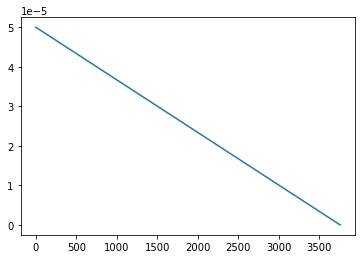

In [229]:
plt.plot([schedule(n) for n in range(num_train_steps)])

In [230]:
#loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction='auto', from_logits=True)
# epoch, lr scheduler and optimizer
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [ ]:
name_log = 'BERT_Apple'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = os.path.join(root_dir,'tensorboard','logs',time.strftime("%m_%d-%H_%M"),name_log), write_graph=True)
history = model.fit(tfdataset_train,validation_data= tfdataset_validation, epochs=3, class_weight = class_weight, callbacks=[tensorboard_cb,checkpoint_cb])

Epoch 1/3
   1/1252 [..............................] - ETA: 9:00:22 - loss: 0.6590 - sparse_categorical_accuracy: 0.6875

In [196]:
history.history

{'loss': [0.5976101756095886, 0.6012696027755737, 0.6005991101264954],
 'sparse_categorical_accuracy': [0.8571428656578064,
  0.8928571343421936,
  0.9285714030265808],
 'val_loss': [0.6646782755851746, 0.6646782755851746, 0.6646782755851746],
 'val_sparse_categorical_accuracy': [0.8571428656578064,
  0.8571428656578064,
  0.8571428656578064]}

In [197]:
#Inpsect model on tensorboard
%reload_ext tensorboard
%tensorboard --logdir=./logs

Reusing TensorBoard on port 6006 (pid 13688), started 0:22:57 ago. (Use '!kill 13688' to kill it.)

## Predictions

In [94]:
pred = np.array(model.predict(tfdataset_test)['logits'])
probabilities = np.array(tf.nn.softmax(pred))
class_pred = np.array(np.argmax(probabilities, axis = 1))

In [95]:
print(pred[:4])
print(probabilities[:4])
print(class_pred[:4])

[[-0.63435155  0.31172195]
 [ 0.30372134 -0.22592731]
 [-0.23194493  0.15245272]
 [ 0.23885989 -0.19893216]]
[[0.27967516 0.7203249 ]
 [0.62940115 0.37059882]
 [0.4050667  0.59493333]
 [0.6077328  0.3922672 ]]
[1 0 1 0]


In [96]:
# correct test labels 
y_test = np.array(test_data['basic_sentiment'])


## Accuracy 

In [97]:
#generate confusion matrix
cf_matrix = confusion_matrix(y_test,class_pred)
print(cf_matrix)


[[29  7]
 [10  4]]


[Text(0, 0.5, 'postive'), Text(0, 1.5, 'negative')]

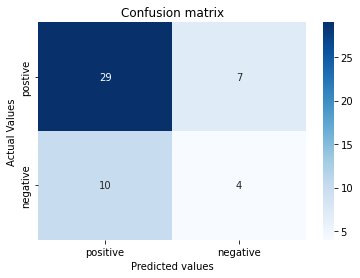

In [98]:
#create a heatmap
import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap = 'Blues')
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['positive','negative'])
ax.yaxis.set_ticklabels(['postive','negative'])

In [ ]:
type(y_test)

In [ ]:
metric = tfa.metrics.F1Score(num_classes=2, threshold=None)
metric.update_state(y_test, probabilities)
#result = metric.result()
#result.numpy()